In [49]:
import brainbox
from one.api import ONE
from utils import download_glm_hmm, save_data_path, val_eid

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches

In [2]:
# Loading up the cleaned data
data = pd.read_pickle('data/ephys_glm_frame_data.pkl')
data.shape

(29023, 31)

In [3]:
# ["still", "move", "wheel_turn", "groom"]
data.columns

Index(['stimOnTrigger_times', 'repNum', 'goCueTrigger_times',
       'quiescencePeriod', 'contrastLeft', 'stimOn_times', 'feedback_times',
       'probabilityLeft', 'response_times', 'rewardVolume', 'choice',
       'goCue_times', 'firstMovement_times', 'contrastRight', 'feedbackType',
       'session', 'stimOff_times', 'glm-hmm_5', 'glm-hmm_3', 'glm-hmm_2',
       'glm-hmm_4', 'intervals_0', 'intervals_1', 'intervals_bpod_0',
       'intervals_bpod_1', 'subject', 'included', 'trial_idx', 'frame_preds',
       'frame_start_index', 'frame_end_index'],
      dtype='object')

In [4]:
def count_max_prob_classes(frame_predictions):
    # Find the index of the max probability in each row
    max_indices = np.argmax(frame_predictions, axis=1)
    
    # Count occurrences of each index
    counts = np.bincount(max_indices, minlength=4)
    
    # Map counts to class names
    class_names = ["still", "move", "wheel_turn", "groom"]
    count_dict = {class_names[i]: counts[i] for i in range(4)}
    
    return count_dict

# sns.heatmap(frame_predictions.T, cmap='turbo', yticklabels=["still", "move", "wheel_turn", "groom"])

In [5]:
adf = pd.DataFrame(columns=["session", "trial_idx", "glm_hmm_state_1", "glm_hmm_state_2", "glm_hmm_state_3", "still", "move", "wheel_turn", "groom"])

for sess_id in val_eid:
    # Get the data for the session
    sess_data = data[data['session'] == sess_id]
    
    # for every trial of this session, get the frame predictions
    for i in range(len(sess_data)):
        # Get the data for this trial
        trial_data = sess_data.iloc[i]
        
        # Get the frame predictions
        frame_predictions = trial_data['frame_preds']

        # Count the number of occurrences of each class
        count_dict = count_max_prob_classes(frame_predictions)

        # get the 3 state glm_hmm_state model
        glm_hmm_state_model = trial_data['glm-hmm_3']

        # store them in the dataframe
        adf = pd.concat([adf, pd.DataFrame({
            "session": [sess_id],
            "trial_idx": [i],
            "glm_hmm_state_1": [glm_hmm_state_model[0]],
            "glm_hmm_state_2": [glm_hmm_state_model[1]],
            "glm_hmm_state_3": [glm_hmm_state_model[2]],
            **count_dict
        })])

/tmp/ipykernel_37609/961223146.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sess_data['max_state'] = sess_data[['glm_hmm_state_1', 'glm_hmm_state_2', 'glm_hmm_state_3']].idxmax(axis=1)


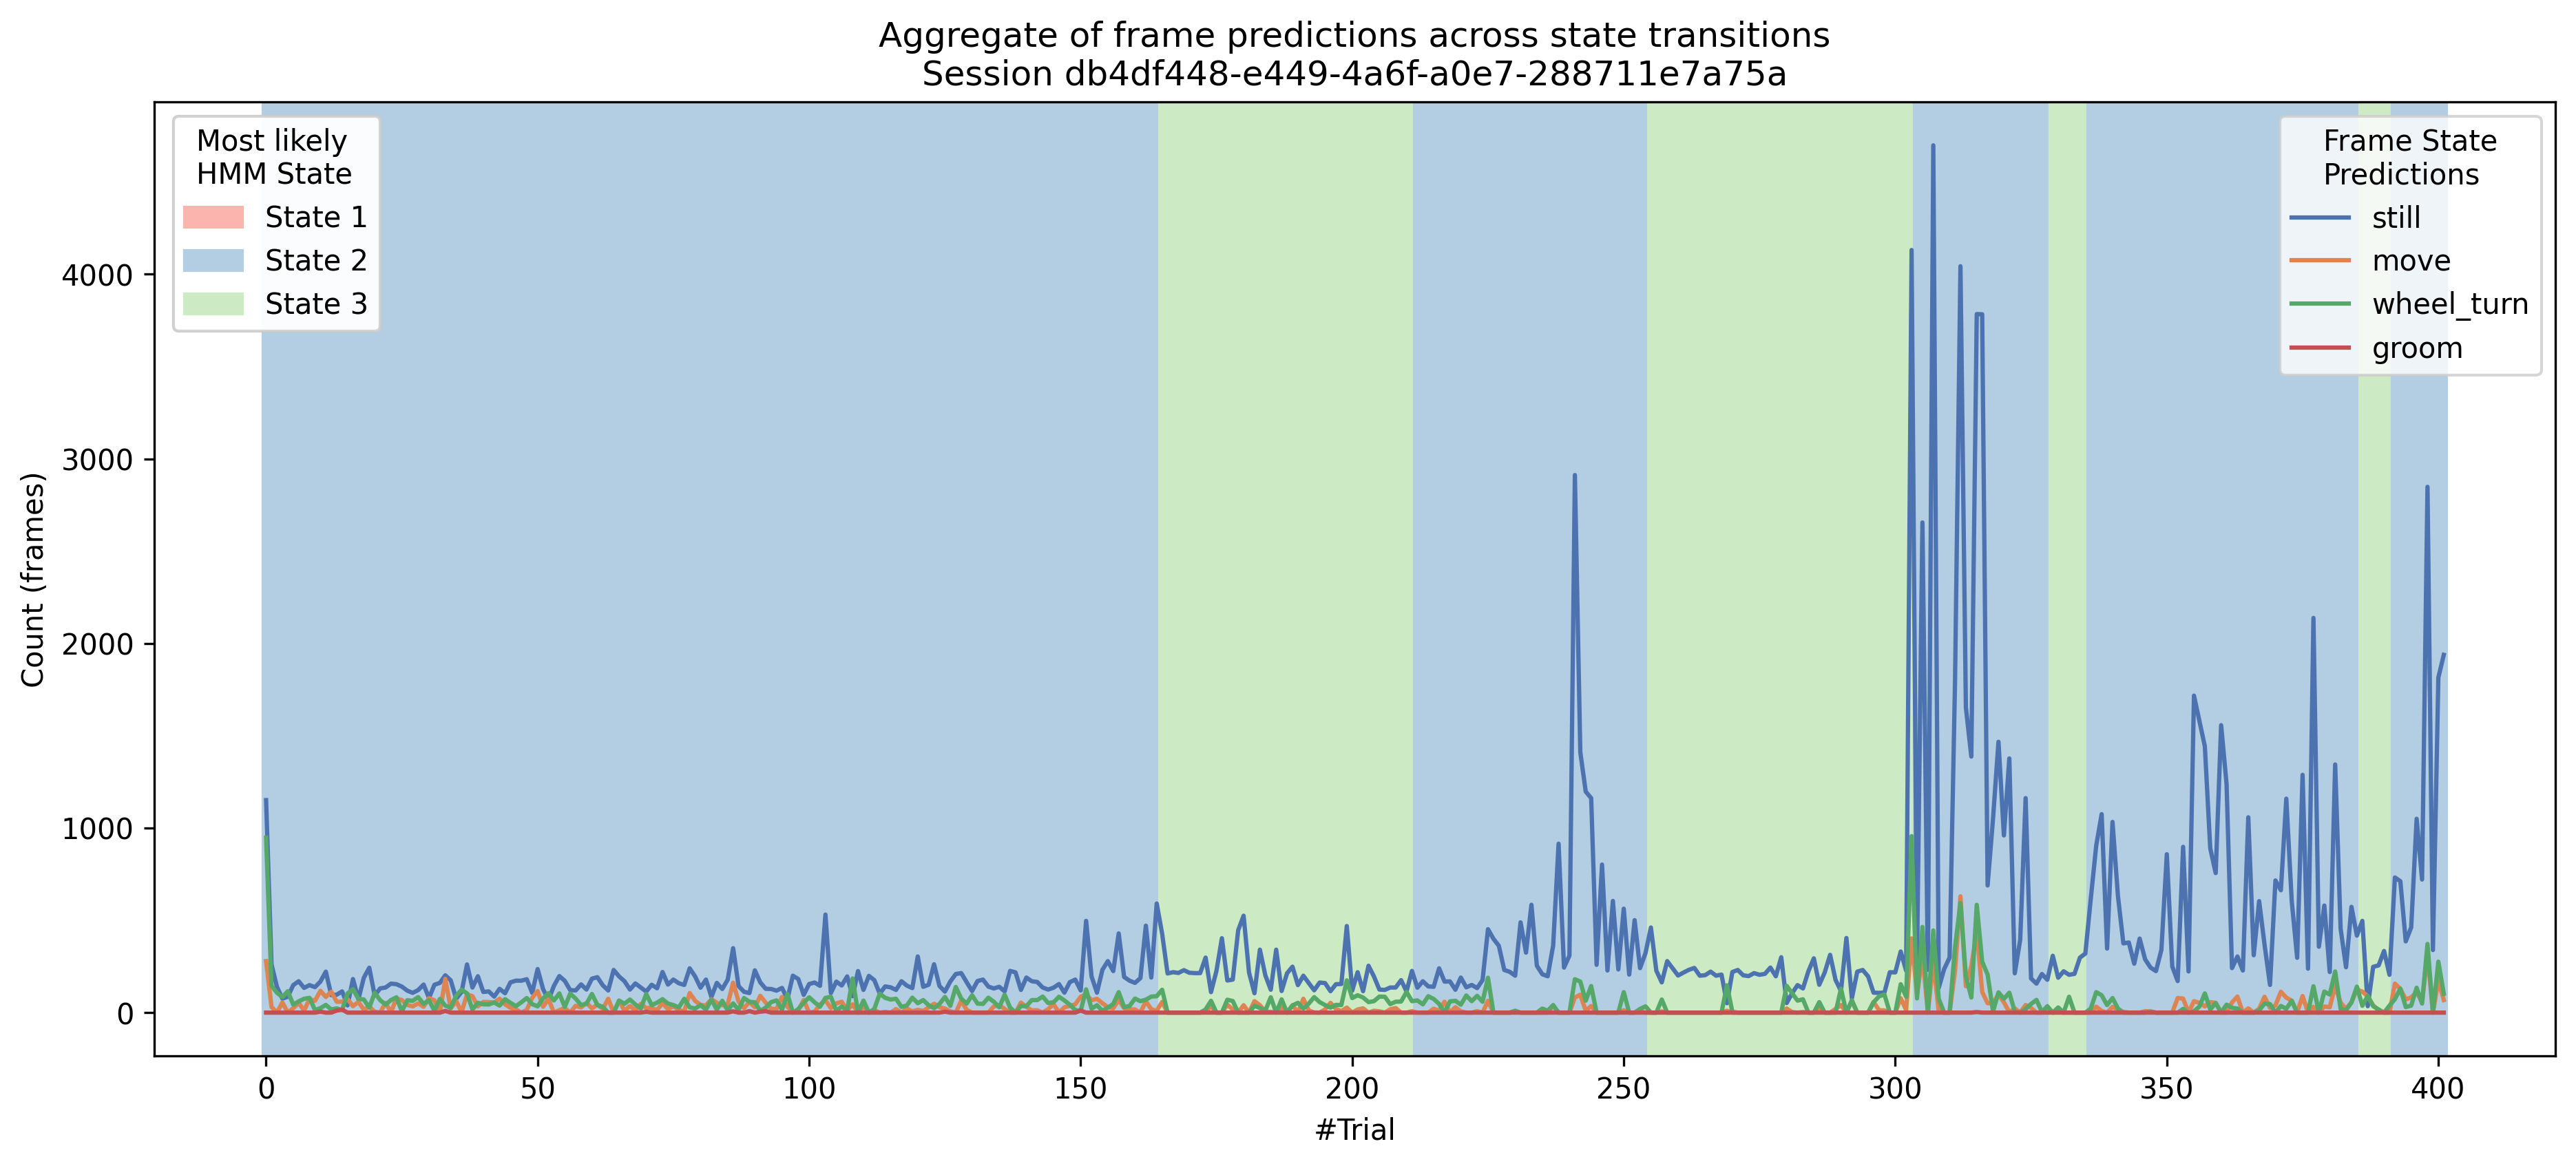

In [99]:
# Define pastel colors for each glm state
colors = {
    'glm_hmm_state_1': '#fbb4ae',  # Light pink
    'glm_hmm_state_2': '#b3cde3',  # Light blue
    'glm_hmm_state_3': '#ccebc5'   # Light green
}

labels = {
    'glm_hmm_state_1': 'State 1',
    'glm_hmm_state_2': 'State 2',
    'glm_hmm_state_3': 'State 3'
}

# plot the "still", "move", "wheel_turn", "groom" counts for each session
for sess_id in val_eid:
    sess_data = adf[adf['session'] == sess_id]

    lenght_of_trials = data[data['session'] == sess_id]['frame_preds'].apply(lambda x: len(x))

    # Calculate max probability for each trial
    sess_data['max_state'] = sess_data[['glm_hmm_state_1', 'glm_hmm_state_2', 'glm_hmm_state_3']].idxmax(axis=1)
    
    # set the color palette of the plot options: deep, muted, pastel, bright, dark, colorblind, Set1-3, Paired, Accent
    sns.set_palette("deep")

    # plot the counts with x as trial_idx, y as count
    plt.figure(figsize=(15, 6), dpi=300)

    plt.plot(sess_data['trial_idx'], sess_data['still'], label='still')
    plt.plot(sess_data['trial_idx'], sess_data['move'], label='move')
    plt.plot(sess_data['trial_idx'], sess_data['wheel_turn'], label='wheel_turn')
    plt.plot(sess_data['trial_idx'], sess_data['groom'], label='groom')

    # Add background color based on the highest probability state
    for _, row in sess_data.iterrows():
        trial_idx = row['trial_idx']
        max_state = row['max_state']
        color = colors[max_state]  # Get color based on the highest probability state
        
        plt.axvspan(trial_idx - 0.5, trial_idx + 0.5, color=color, alpha=1)
    
    # Create custom patches for the second legend
    patches = [mpatches.Patch(color=color, label=labels[state]) for state, color in colors.items()]
    
    # Create the first legend (for the plot lines)
    plot_legend = plt.legend(title='Frame State\nPredictions', loc='upper right', bbox_to_anchor=(1, 1))
    
    # Create the second legend (for the background colors)
    background_legend = plt.legend(handles=patches, title='Most likely \nHMM State', loc='upper right', bbox_to_anchor=(0.1, 1))
    
    # Add the legends to the plot
    plt.gca().add_artist(plot_legend)
    plt.gca().add_artist(background_legend)
    
    plt.title(f"Aggregate of frame predictions across state transitions\nSession {sess_id}")
    plt.xlabel("#Trial")
    plt.ylabel("Count (frames)")
    
    plt.show()
    
    break
    

/tmp/ipykernel_37609/2972847447.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sess_data['max_state'] = sess_data[['glm_hmm_state_1', 'glm_hmm_state_2', 'glm_hmm_state_3']].idxmax(axis=1)


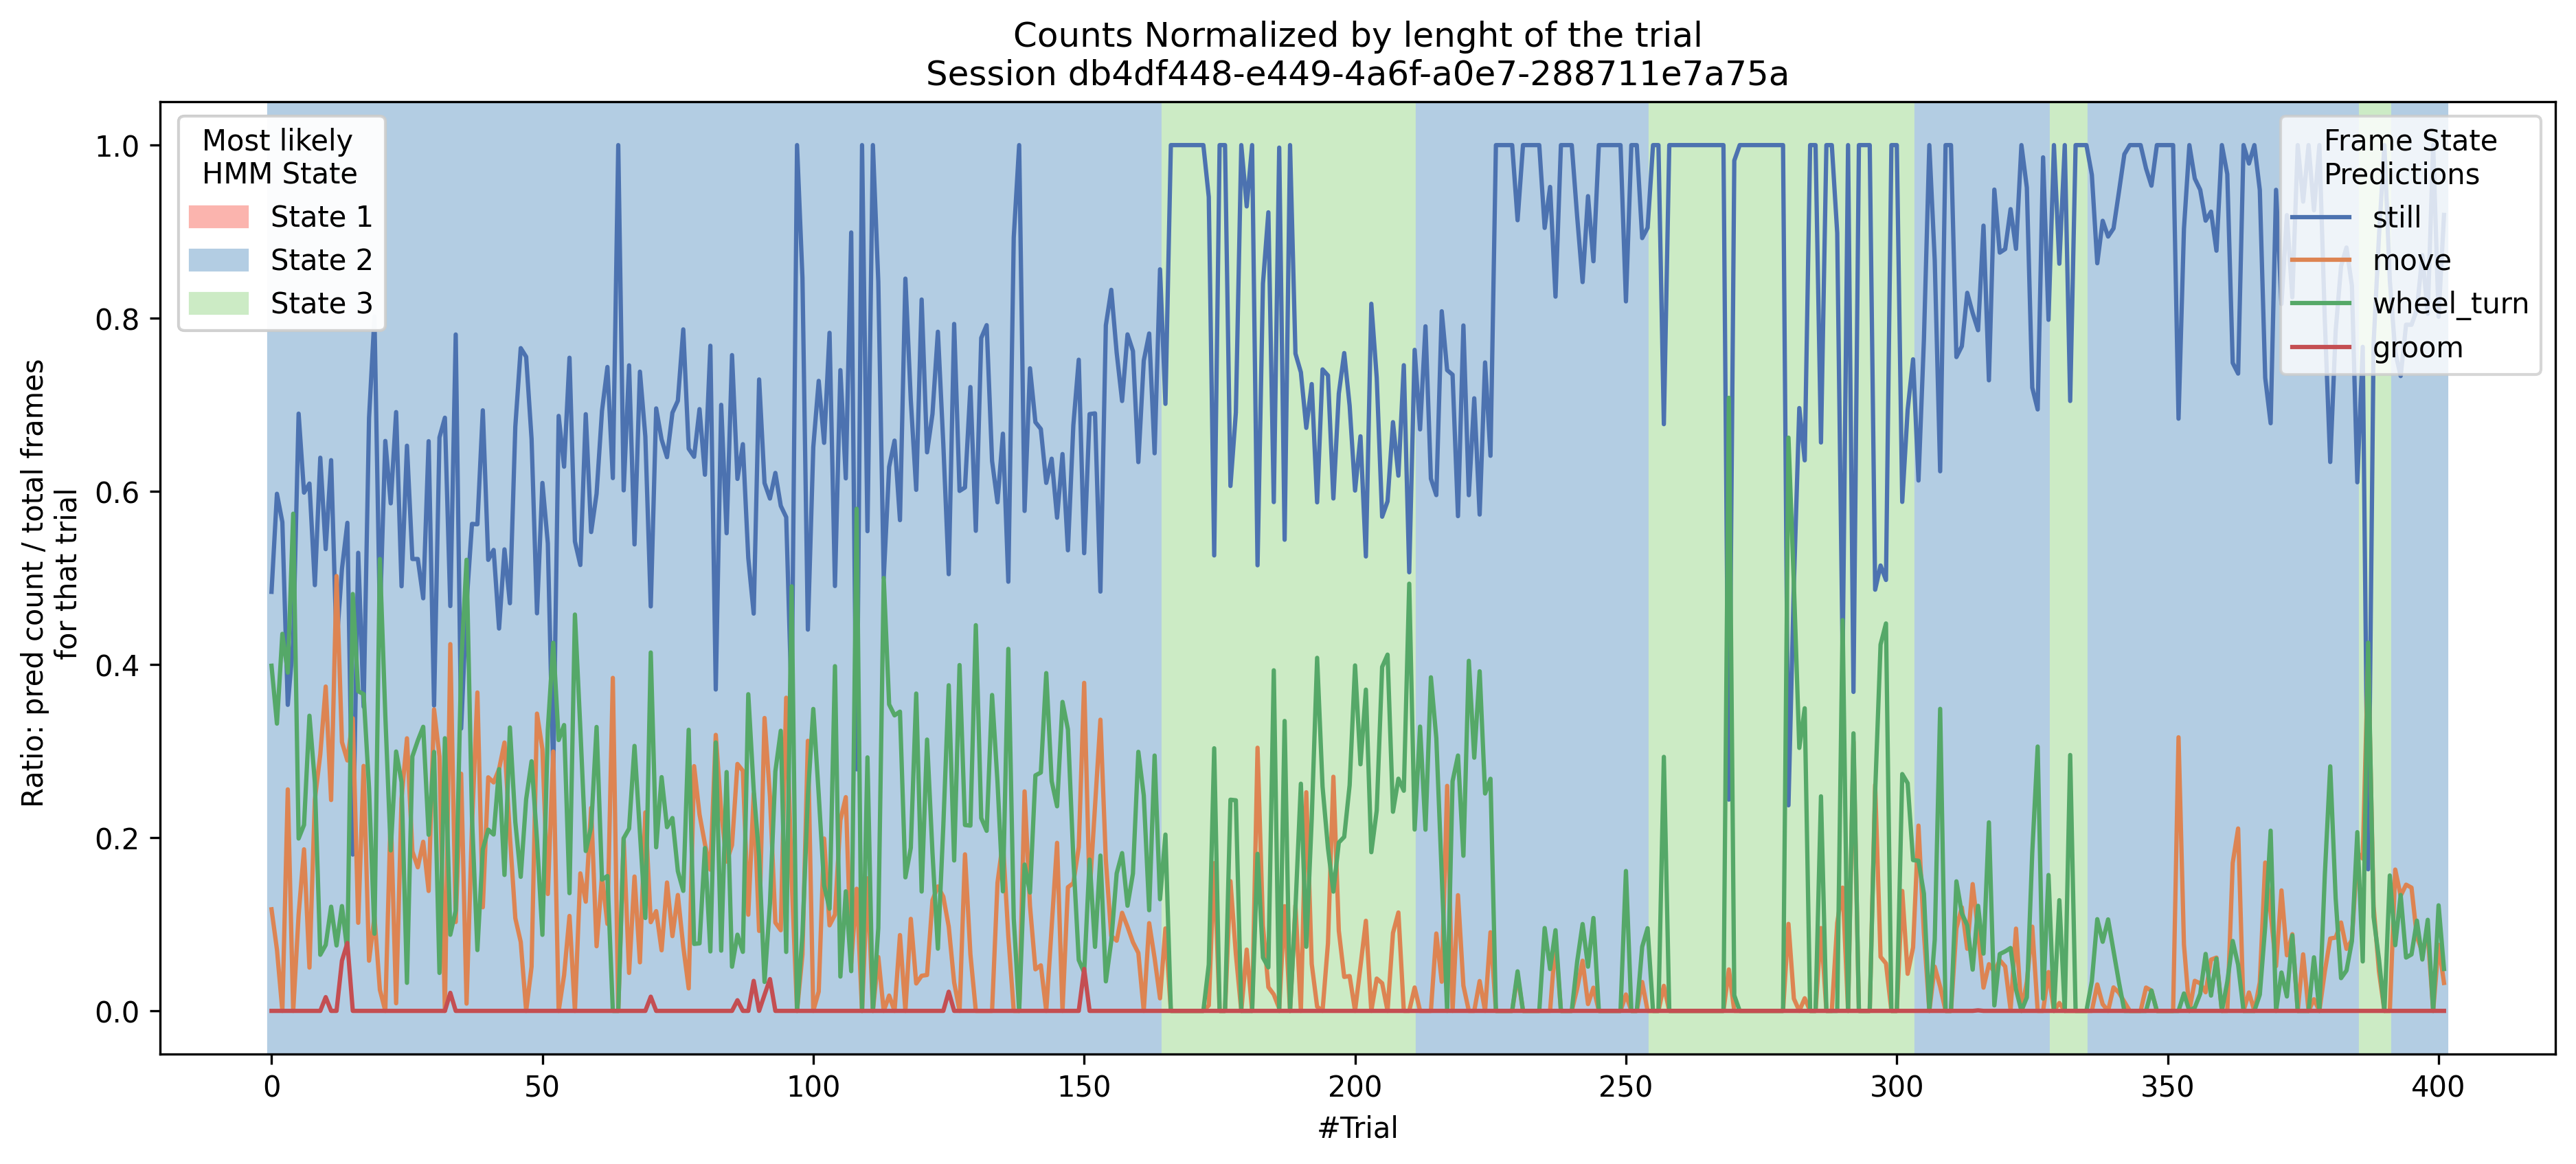

In [101]:
# Define pastel colors for each glm state
colors = {
    'glm_hmm_state_1': '#fbb4ae',  # Light pink
    'glm_hmm_state_2': '#b3cde3',  # Light blue
    'glm_hmm_state_3': '#ccebc5'   # Light green
}

labels = {
    'glm_hmm_state_1': 'State 1',
    'glm_hmm_state_2': 'State 2',
    'glm_hmm_state_3': 'State 3'
}

# plot the "still", "move", "wheel_turn", "groom" counts for each session
for sess_id in val_eid:
    sess_data = adf[adf['session'] == sess_id]

    lenght_of_trials = data[data['session'] == sess_id]['frame_preds'].apply(lambda x: len(x))

    # Calculate max probability for each trial
    sess_data['max_state'] = sess_data[['glm_hmm_state_1', 'glm_hmm_state_2', 'glm_hmm_state_3']].idxmax(axis=1)
    
    # set the color palette of the plot options: deep, muted, pastel, bright, dark, colorblind, Set1-3, Paired, Accent
    sns.set_palette("deep")

    # plot the counts with x as trial_idx, y as count
    plt.figure(figsize=(15, 6), dpi=300)

    plt.plot(sess_data['trial_idx'], sess_data['still'].to_numpy()/lenght_of_trials, label='still')
    plt.plot(sess_data['trial_idx'], sess_data['move'].to_numpy()/lenght_of_trials, label='move')
    plt.plot(sess_data['trial_idx'], sess_data['wheel_turn'].to_numpy()/lenght_of_trials, label='wheel_turn')
    plt.plot(sess_data['trial_idx'], sess_data['groom'].to_numpy()/lenght_of_trials, label='groom')

    # Add background color based on the highest probability state
    for _, row in sess_data.iterrows():
        trial_idx = row['trial_idx']
        max_state = row['max_state']
        color = colors[max_state]  # Get color based on the highest probability state
        
        plt.axvspan(trial_idx - 0.5, trial_idx + 0.5, color=color, alpha=1)
    
    # Create custom patches for the second legend
    patches = [mpatches.Patch(color=color, label=labels[state]) for state, color in colors.items()]
    
    # Create the first legend (for the plot lines)
    plot_legend = plt.legend(title='Frame State\nPredictions', loc='upper right', bbox_to_anchor=(1, 1))
    
    # Create the second legend (for the background colors)
    background_legend = plt.legend(handles=patches, title='Most likely \nHMM State', loc='upper right', bbox_to_anchor=(0.1, 1))
    
    # Add the legends to the plot
    plt.gca().add_artist(plot_legend)
    plt.gca().add_artist(background_legend)
    
    plt.title(f"Counts Normalized by lenght of the trial\nSession {sess_id}")
    plt.xlabel("#Trial")
    plt.ylabel("Ratio: pred count / total frames \n for that trial")
    
    plt.show()
    
    break
    

/tmp/ipykernel_37609/2784709939.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


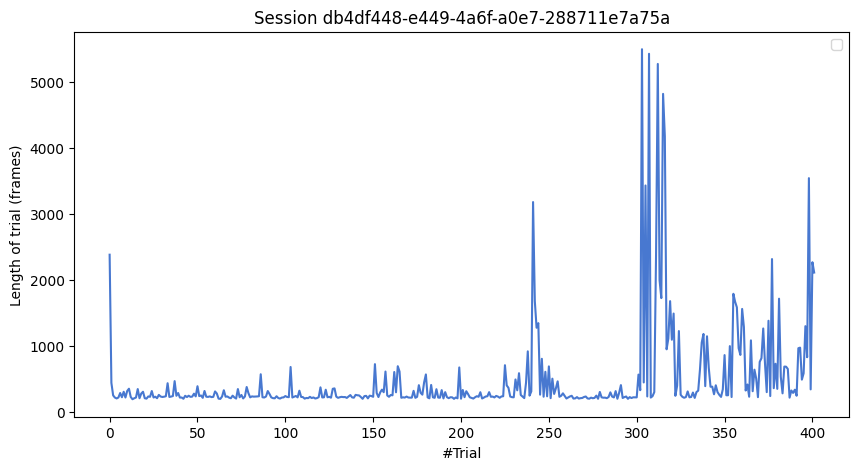

In [28]:
# plot the length of the trials
for sess_id in val_eid:
    sess_data = data[data['session'] == sess_id]

    lenght_of_trials = sess_data['frame_preds'].apply(lambda x: len(x))
    
    # set the color palette of the plot options: deep, muted, pastel, bright, dark, colorblind
    sns.set_palette("muted")

    # plot the counts with x as trial_idx, y as count
    plt.figure(figsize=(10, 5))
    plt.plot(sess_data['trial_idx'], lenght_of_trials)
    plt.legend()
    plt.title(f"Session {sess_id}")

    plt.xlabel("#Trial")
    plt.ylabel("Length of trial (frames)")

    plt.show()
    break

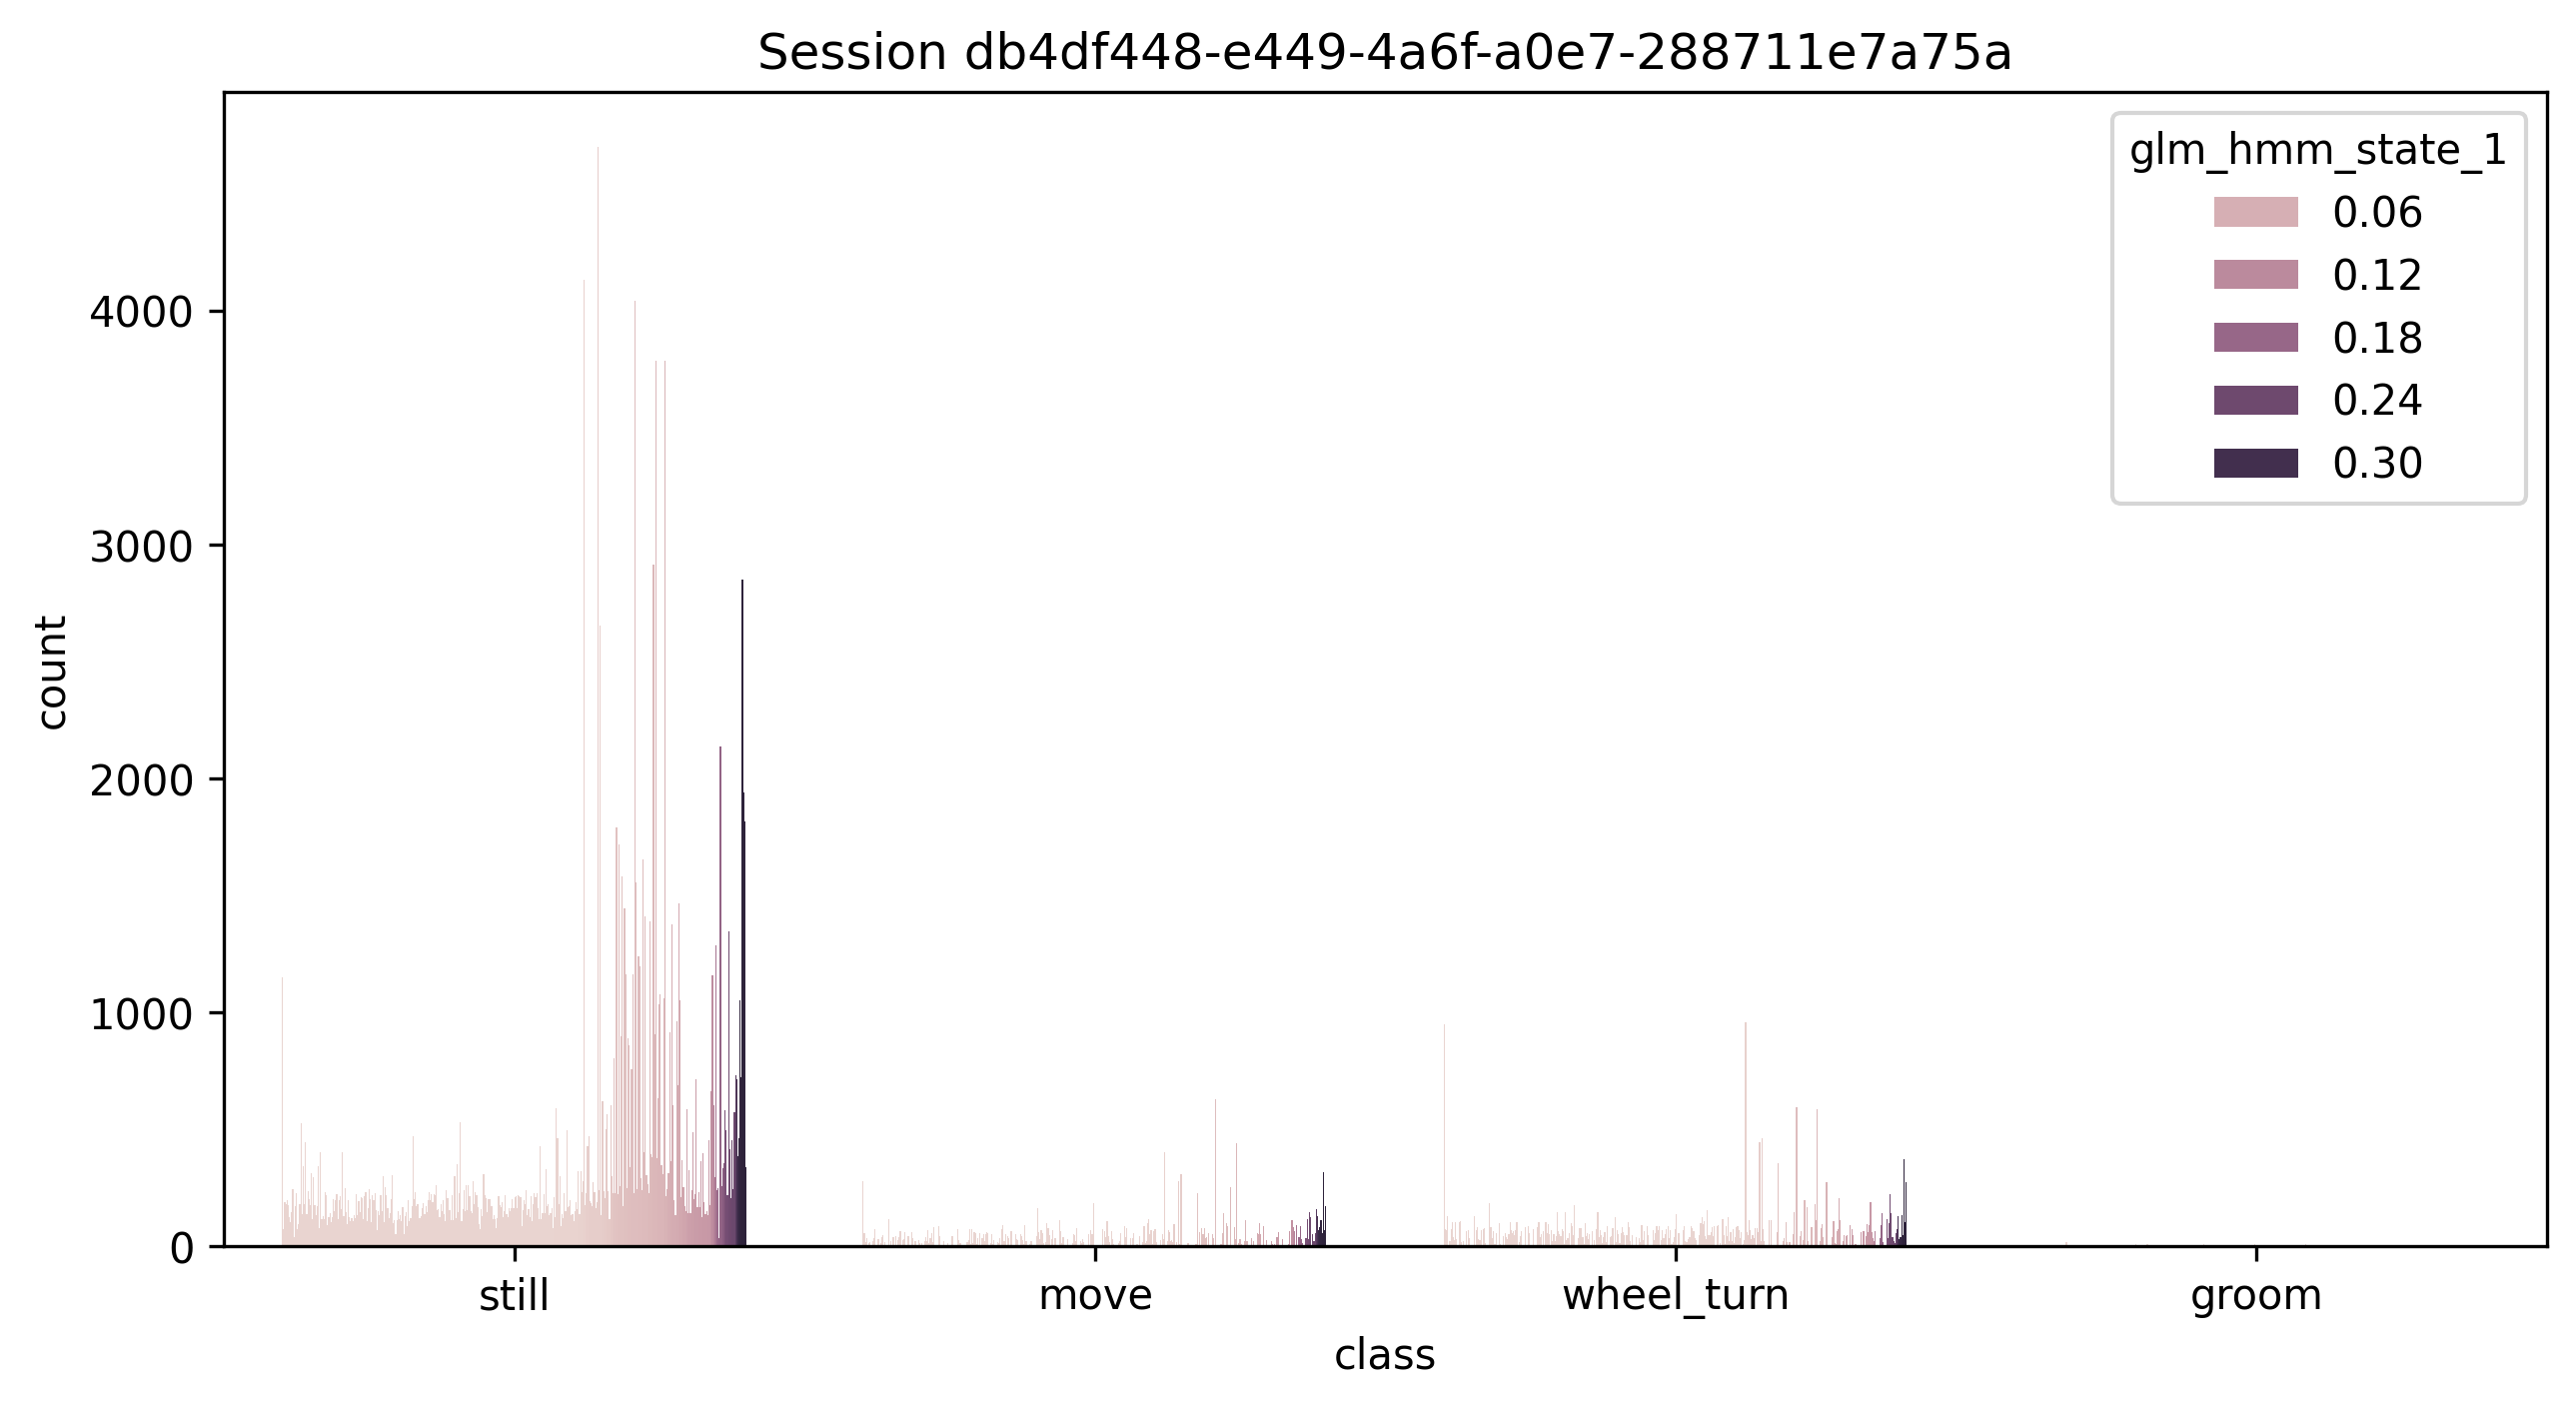

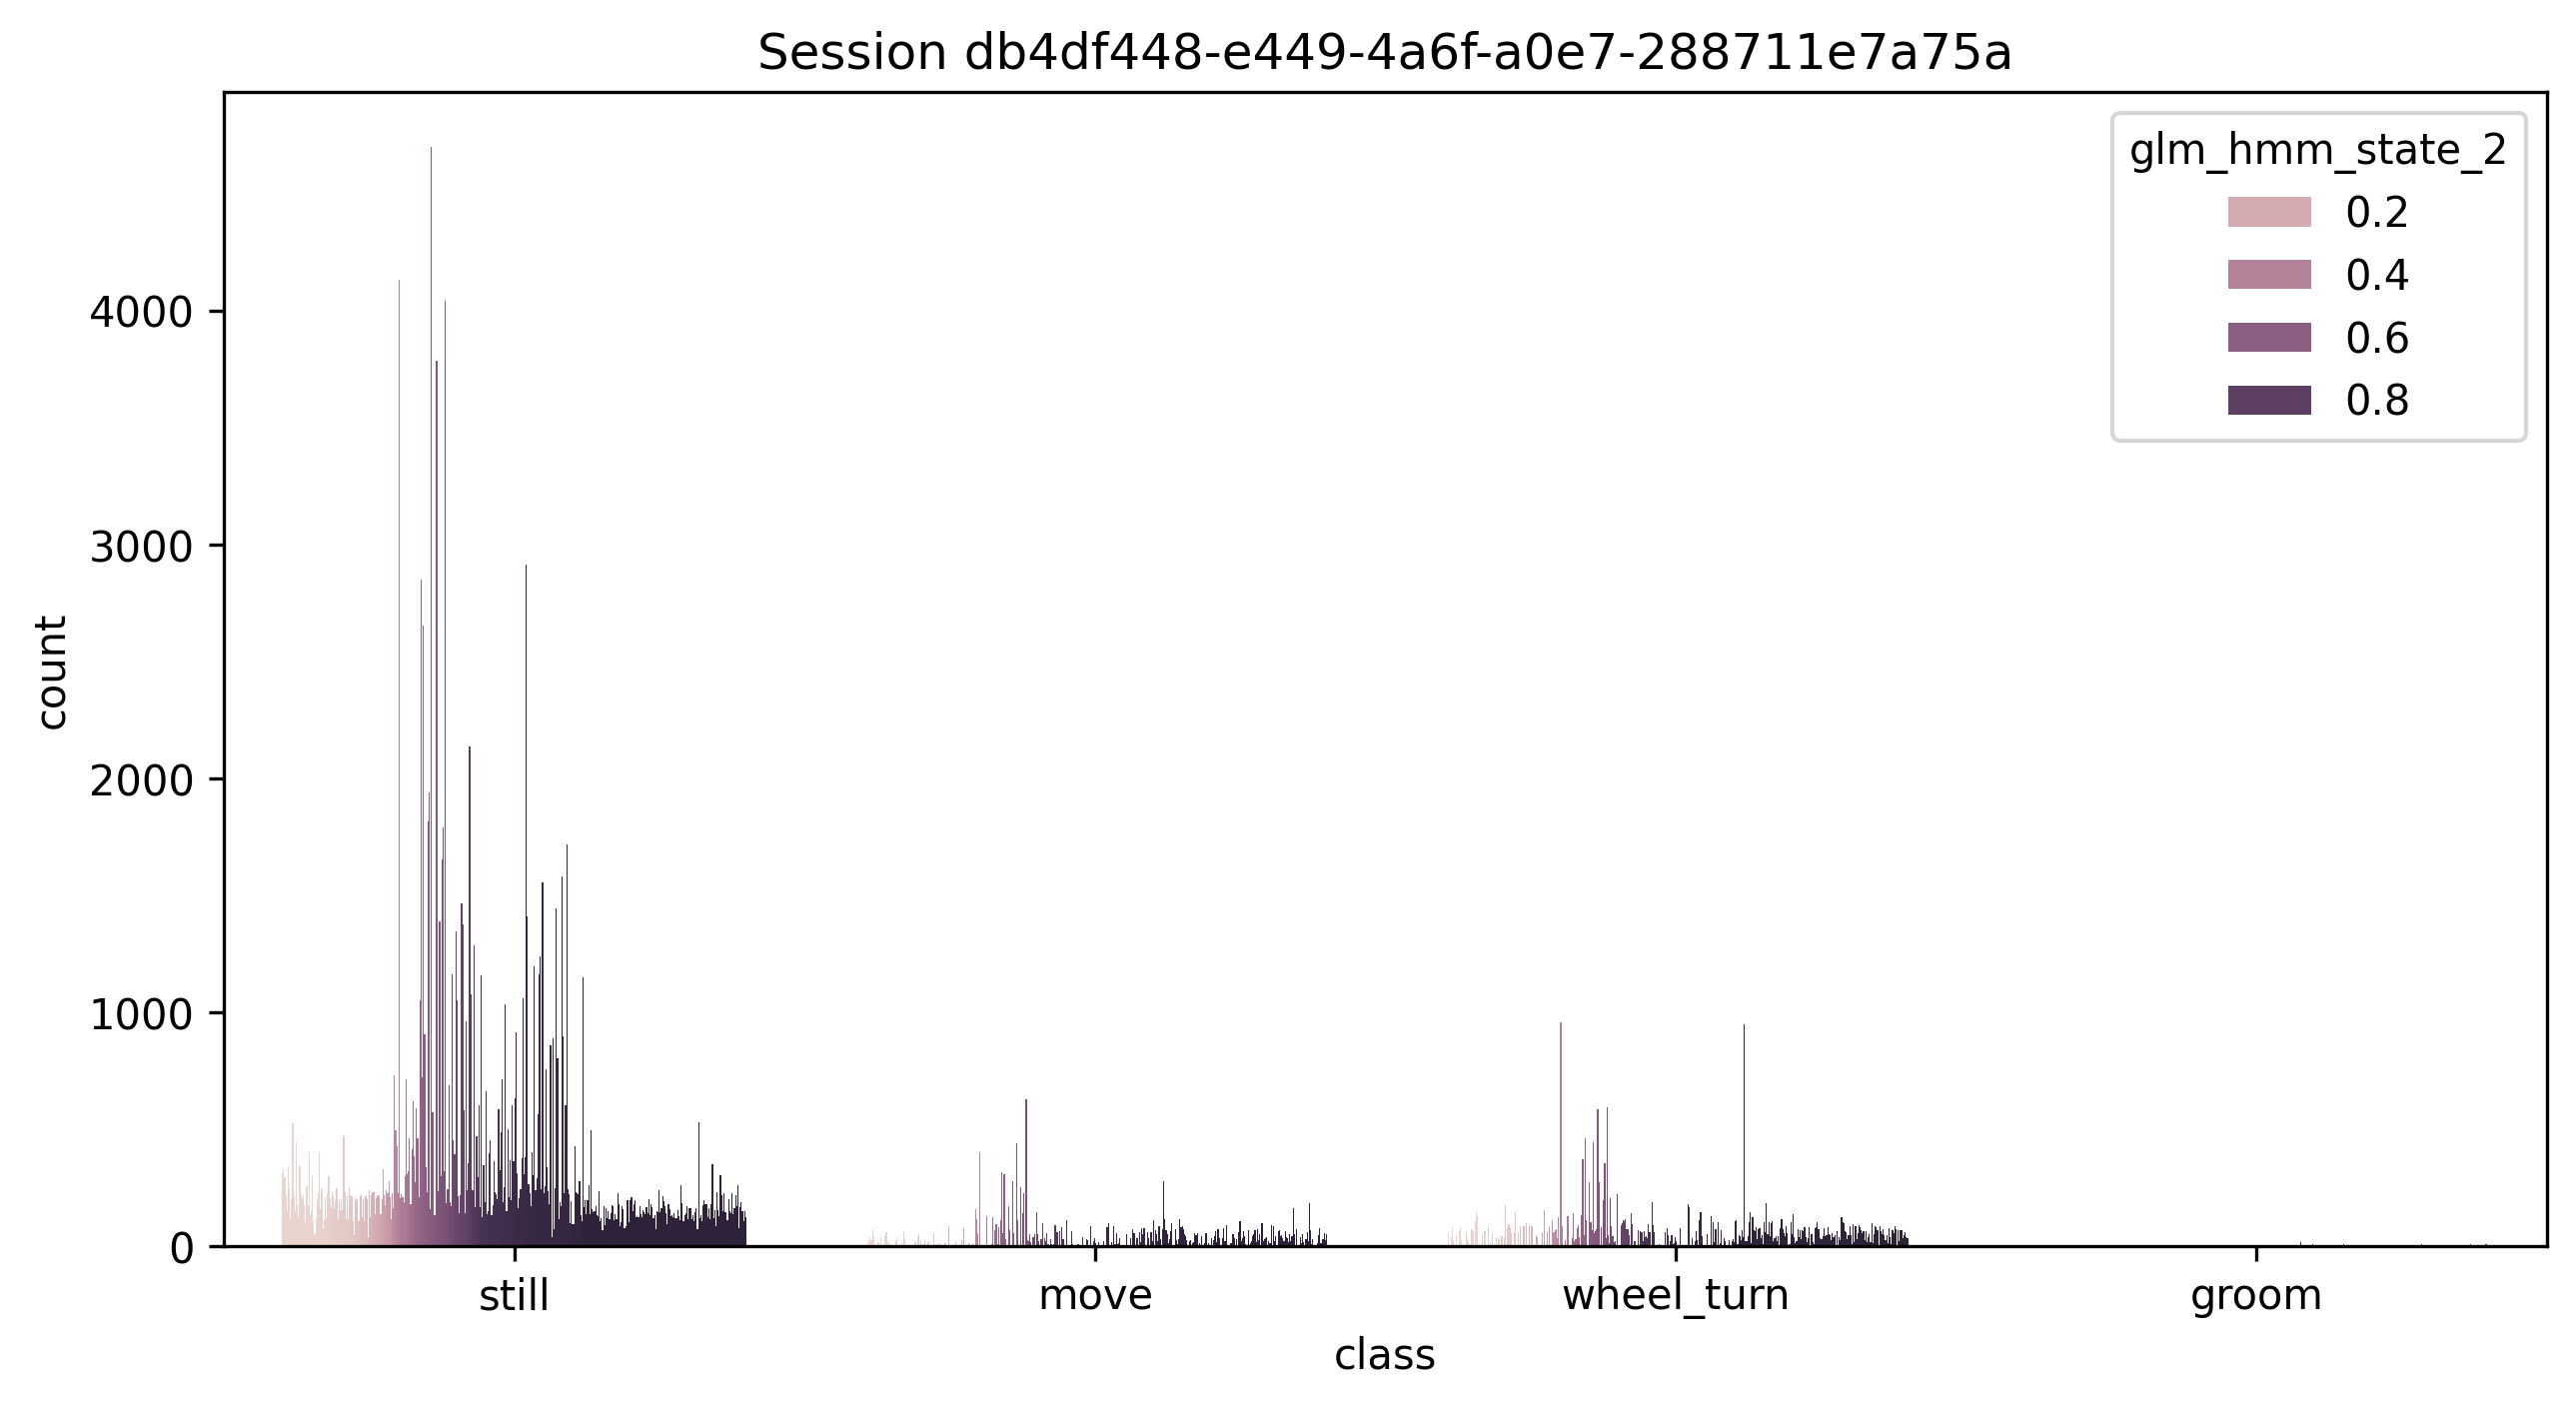

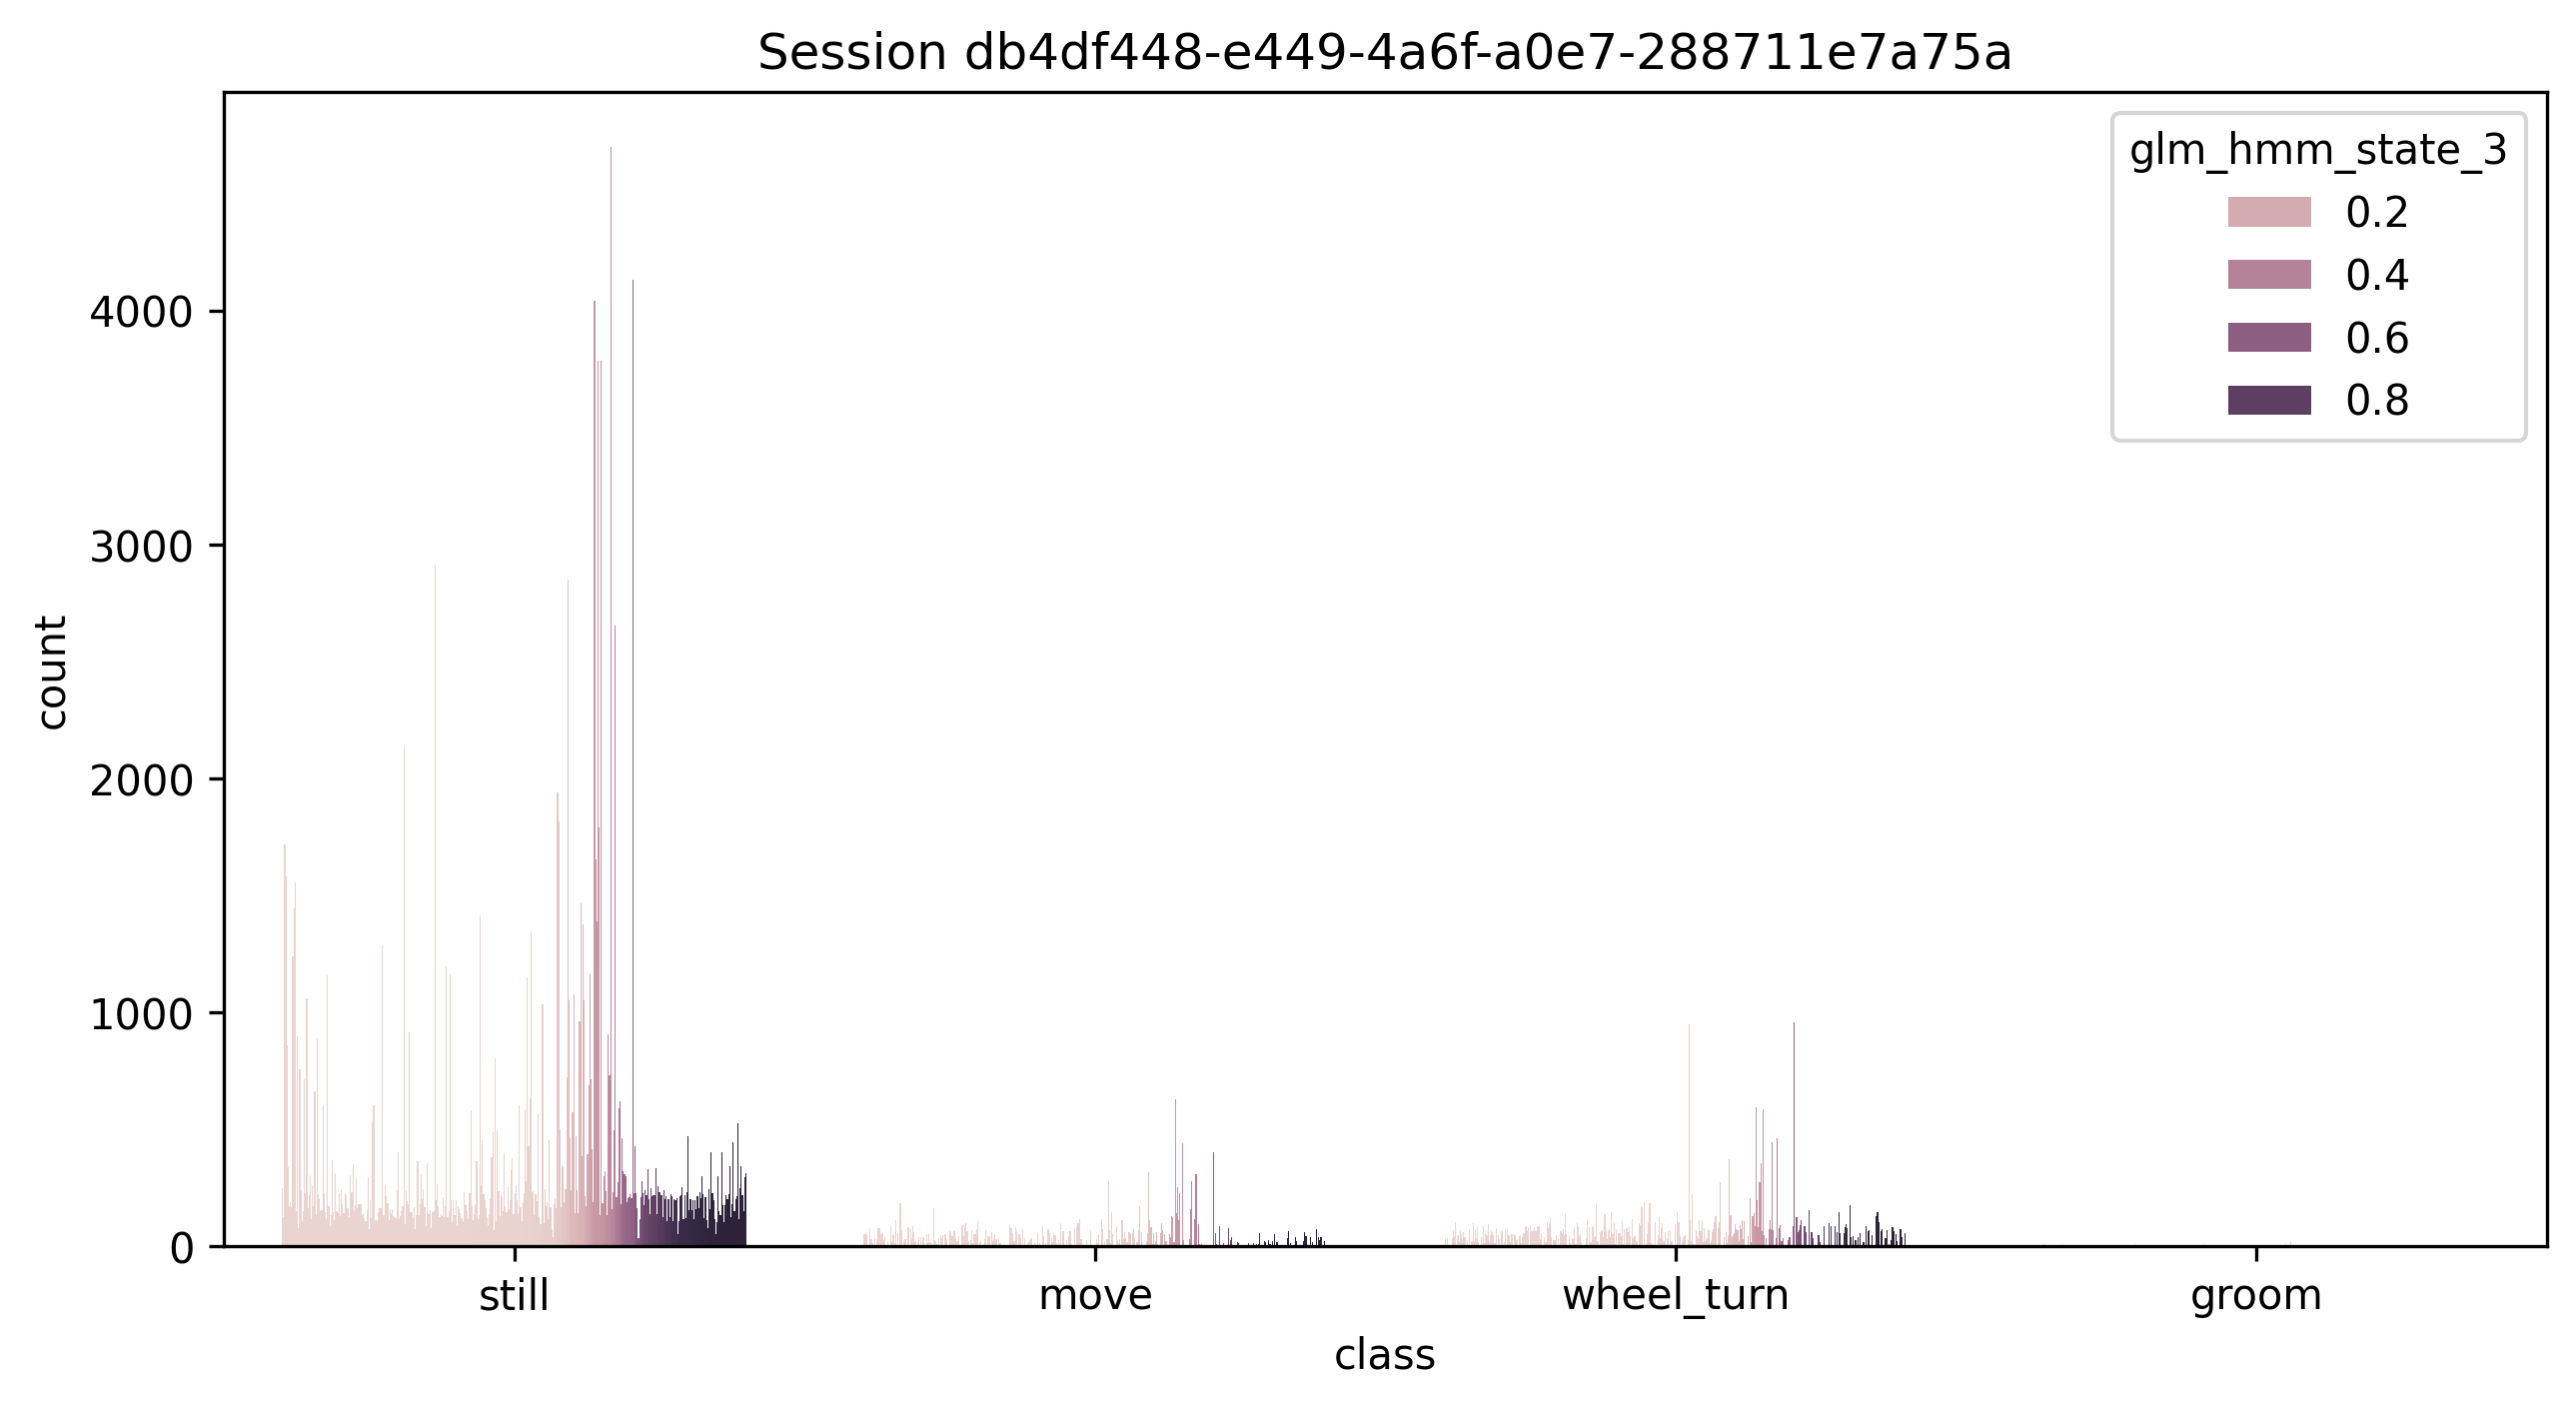

In [104]:
# plot the "still", "move", "wheel_turn", "groom" counts for each session

for sess_id in val_eid:
    sess_data = adf[adf['session'] == sess_id]
    sess_data = sess_data.drop(columns=['session', 'trial_idx'])
    sess_data = sess_data.groupby(['glm_hmm_state_1', 'glm_hmm_state_2', 'glm_hmm_state_3']).sum()
    sess_data = sess_data.reset_index()
    sess_data = sess_data.melt(id_vars=['glm_hmm_state_1', 'glm_hmm_state_2', 'glm_hmm_state_3'], var_name='class', value_name='count')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
    sns.barplot(data=sess_data, x='class', y='count', hue='glm_hmm_state_1', ax=ax)
    ax.set_title(f"Session {sess_id}")
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
    sns.barplot(data=sess_data, x='class', y='count', hue='glm_hmm_state_2', ax=ax)
    ax.set_title(f"Session {sess_id}")
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
    sns.barplot(data=sess_data, x='class', y='count', hue='glm_hmm_state_3', ax=ax)
    ax.set_title(f"Session {sess_id}")
    plt.show()
    break